# Explore driftscan FFIs

Analysis for driftscan FFIs!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from astropy.io import fits
import astropy.visualization
from fast_histogram import histogram1d

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Estimate the rate of motion

In [4]:
cols = ['FFI num', 'Channel', 'x1', 'y1', 'x2', 'y2', 'length_pix',
       'motion_deg_hr', 'angle_deg']

In [5]:
df_motion = pd.read_csv('../data/driftscan_FFI/motion_estimates/lengths-Table 1.csv', names=cols, skiprows=1)

In [6]:
df_motion.head()

,FFI num,Channel,x1,y1,x2,y2,length_pix,motion_deg_hr,angle_deg
0,1,41,420,548,572,576.0,155,0.350,10.4
1,1,53,641,488,791,515.0,152,0.346,10.2
2,2,41,260,866,415,892.0,157,0.356,9.5
3,2,53,871,532,1025,558.0,156,0.354,9.6
4,3,41,568,342,724,369.0,158,0.359,9.8


In [7]:
df_time = pd.read_csv('../data/driftscan_FFI/motion_estimates/FFI_acq_time-Table 1.csv', usecols=['FFI num','t-t0 (min)'])
df_time

,FFI num,t-t0 (min)
0,1,0.000
1,2,46.433
2,3,93.400
3,4,420.450
4,5,626.317


In [8]:
df = pd.merge(df_time, df_motion, on='FFI num')

In [9]:
df.head()

,FFI num,t-t0 (min),Channel,x1,y1,x2,y2,length_pix,motion_deg_hr,angle_deg
0,1,0.000,41,420,548,572,576.0,155,0.350,10.4
1,1,0.000,53,641,488,791,515.0,152,0.346,10.2
2,2,46.433,41,260,866,415,892.0,157,0.356,9.5
3,2,46.433,53,871,532,1025,558.0,156,0.354,9.6
4,3,93.400,41,568,342,724,369.0,158,0.359,9.8


In [10]:
import seaborn as sns

In [11]:
sns.set_context('talk')

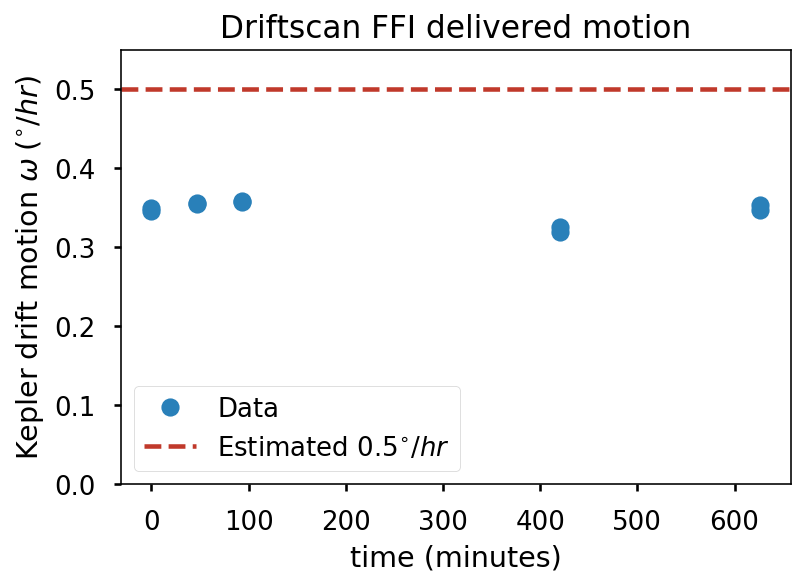

In [12]:
plt.plot(df['t-t0 (min)'], df['motion_deg_hr'], 'o', color='#2980b9', label='Data')
plt.xlabel('time (minutes)')
plt.ylabel('Kepler drift motion $\omega \; (^{\circ}/hr)$')
plt.axhline(0.5, color='#c0392b', linestyle='dashed', label='Estimated $0.5^{\circ}/hr$')
plt.ylim(0, 0.55)
plt.title('Driftscan FFI delivered motion')
plt.legend()
plt.savefig('../figures/driftscan_motion.pdf', bbox_inches='tight')

In [13]:
df['motion_deg_hr'].mean()

0.3467

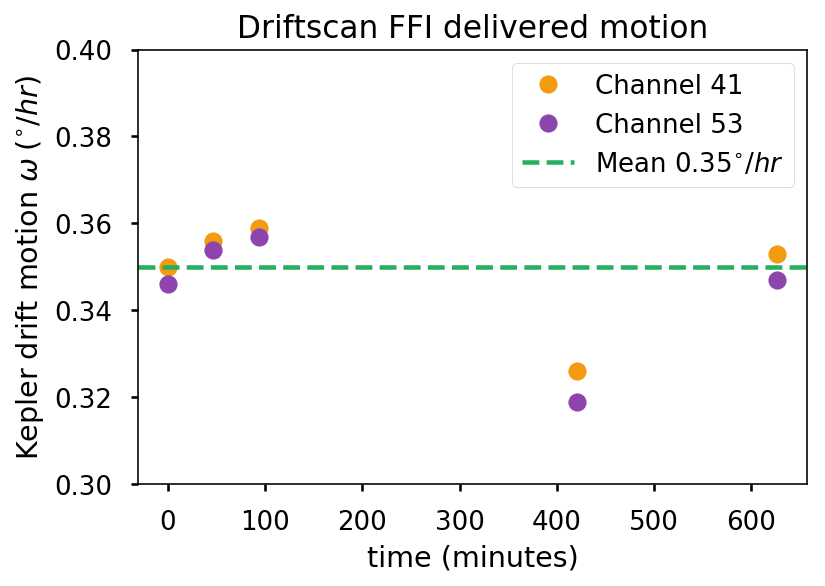

In [14]:
ch_41 = df['Channel'] ==41
ch_53 = df['Channel'] ==53
plt.plot(df['t-t0 (min)'][ch_41], df['motion_deg_hr'][ch_41], 'o', color='#f39c12', label='Channel 41')
plt.plot(df['t-t0 (min)'][ch_53], df['motion_deg_hr'][ch_53], 'o', color='#8e44ad', label='Channel 53')
plt.xlabel('time (minutes)')
plt.ylabel('Kepler drift motion $\omega \; (^{\circ}/hr)$')
plt.axhline(0.35, color='#27ae60', linestyle='dashed', label='Mean $0.35^{\circ}/hr$')
plt.ylim(0.3, 0.4)
plt.title('Driftscan FFI delivered motion')
plt.legend()
plt.savefig('../figures/driftscan_motion_zoom.pdf', bbox_inches='tight')

## Read in a driftscan FFI

In [28]:
hdu = fits.open('../data/C17_driftscans/ffi-kacr2120/kplr2018131024020_ffi-orig.fits')

The FFIs are comprised of many individual modules and channels, etc.  Let's look at one of them.  Module 13 is near "on-axis" of the optical system: it's in the middle of the field of view and should therefore have better-than-average image quality.

In [29]:
ch41 = hdu[41]

In [30]:
ch41.data.shape

(1070, 1132)

In [31]:
ch41.data.min()

187386

Negative values foil logarithmic transformations.  Add a bias value of 500.0

In [32]:
dat = ch41.data
logdat = np.log10(dat)

In [33]:
minmax = astropy.visualization.MinMaxInterval()

In [34]:
vmin, vmax = minmax.get_limits(logdat)
vmin, vmax

(5.272737140714671, 6.2569567105182)

In [35]:
x = np.linspace(vmin, vmax, 200)
y = histogram1d(logdat.reshape(-1), bins=200, range=(vmin, vmax))

Let's improve the *screen stretch* for readability.

In [36]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 95.0)
vmin, vmax = good_interval.get_limits(logdat)

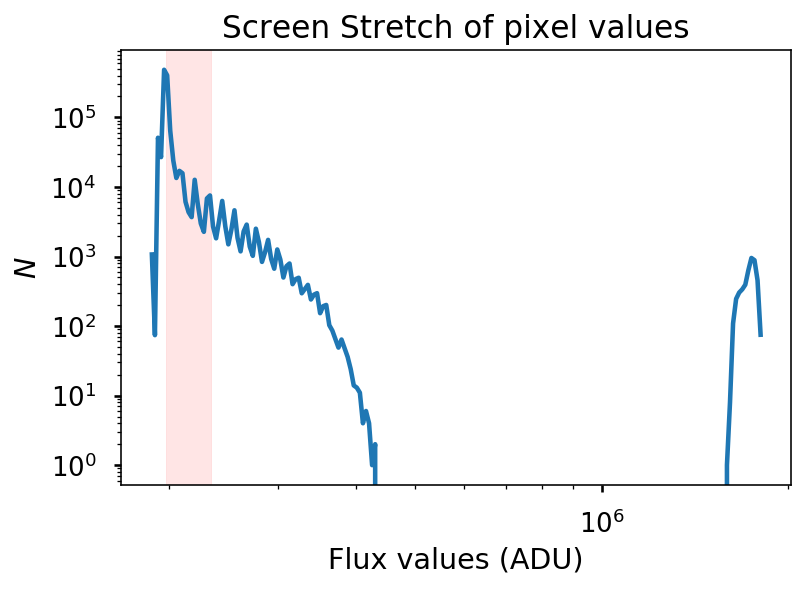

In [37]:
plt.plot(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux values (ADU)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');

In [38]:
norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

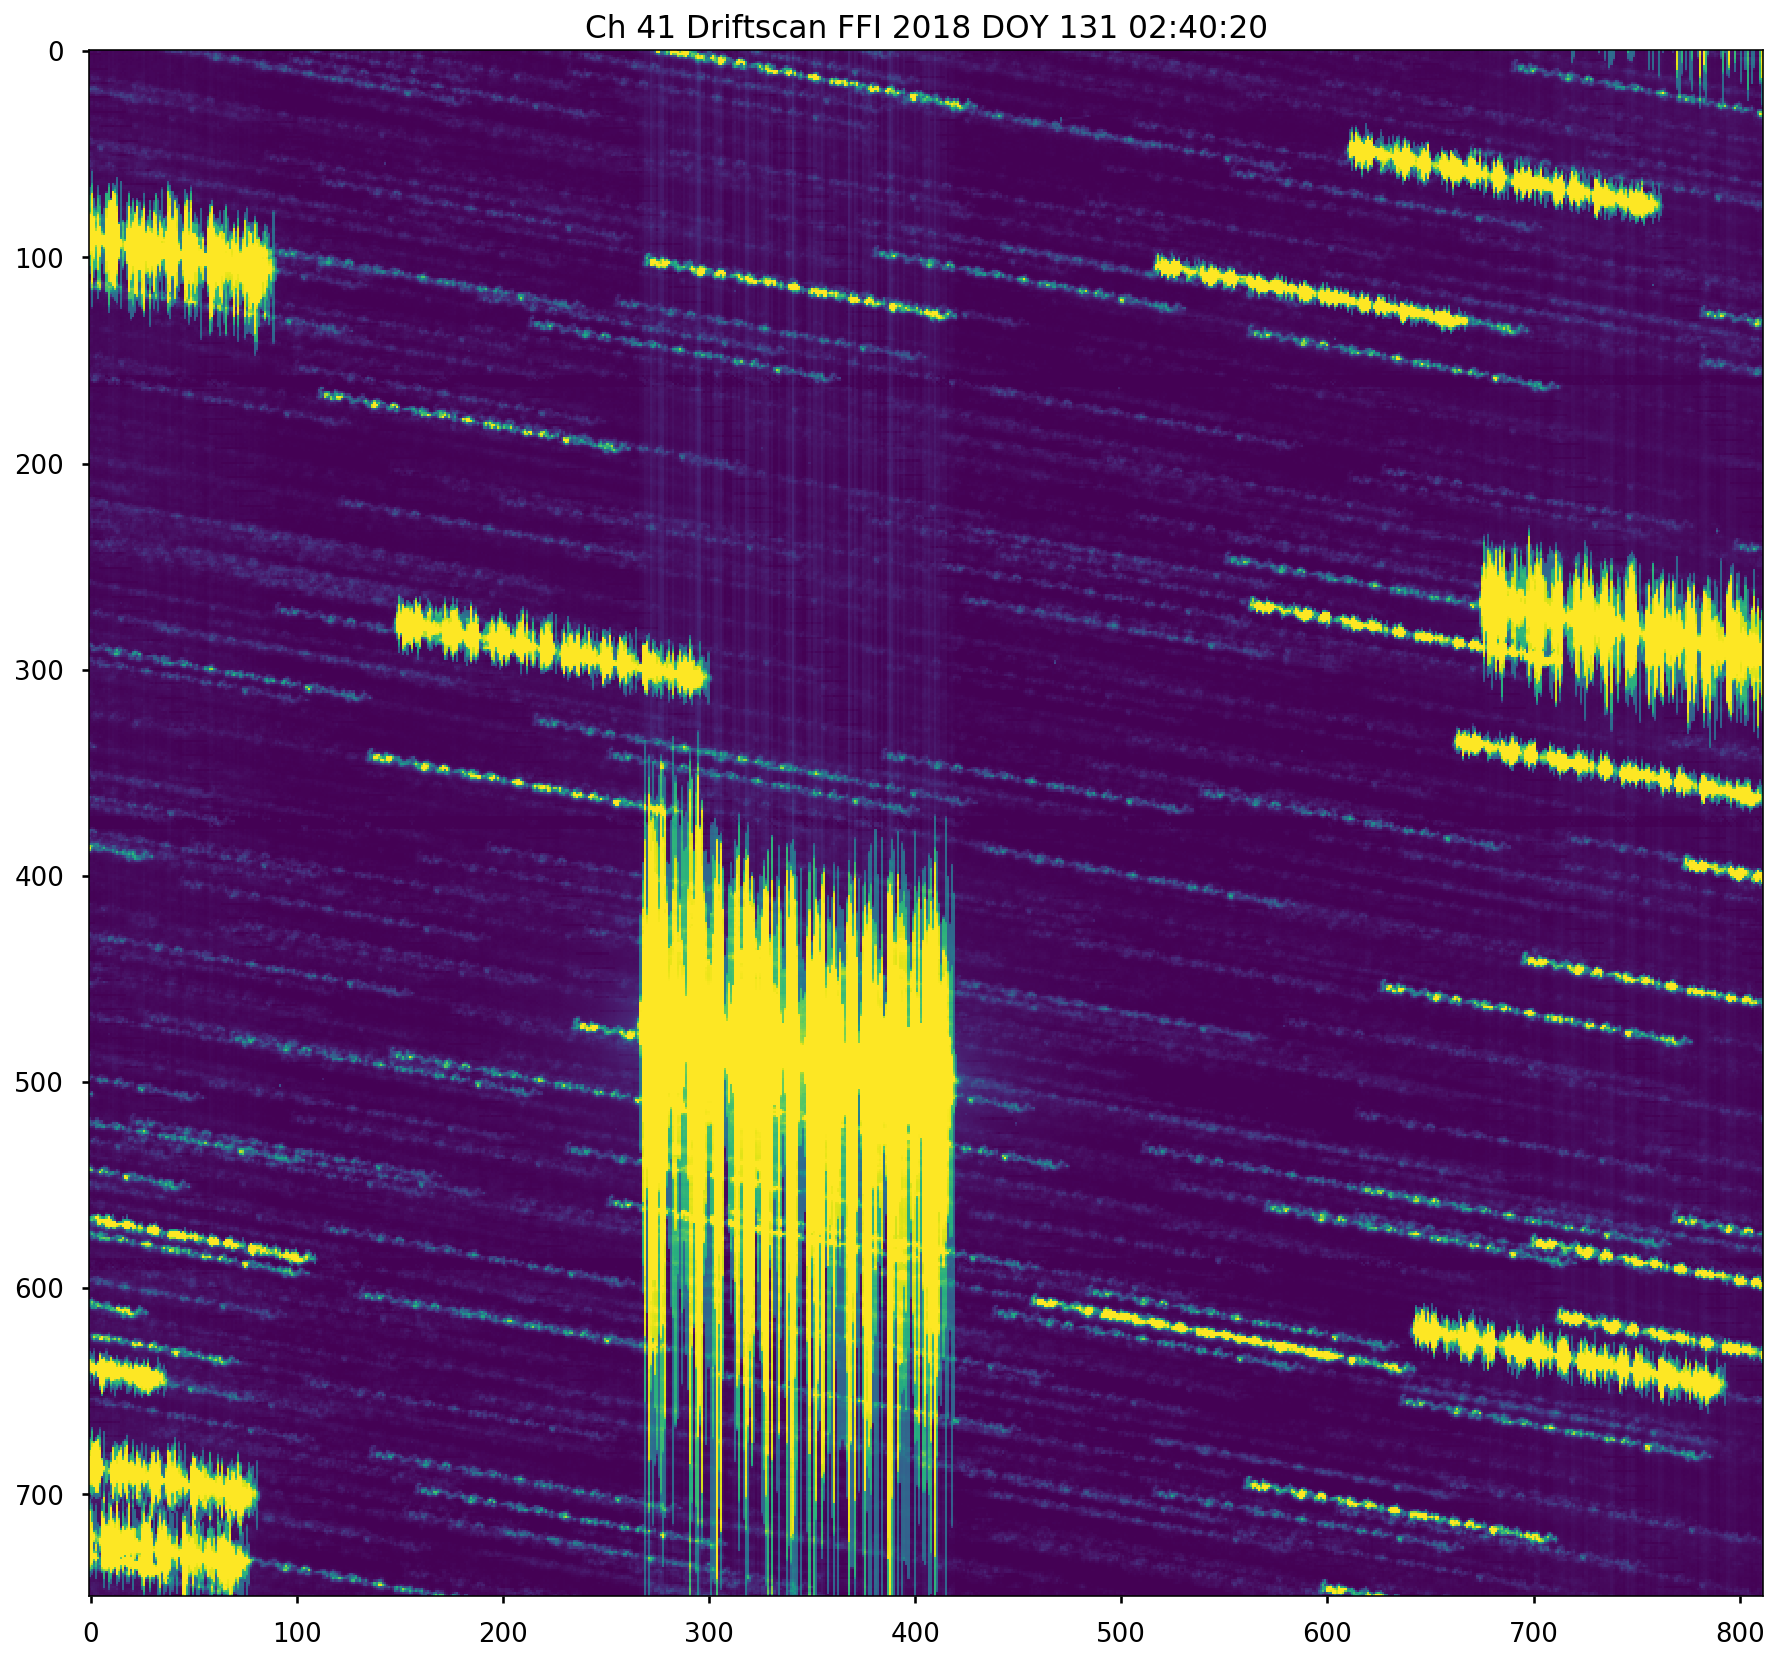

In [39]:
plt.figure(figsize=(15,15))
plt.imshow(dat[270:-50, 270:-50], norm=norm)
#plt.title('Ch 41 Driftscan FFI 2018 DOY 131 04:13:44')
#plt.title('Ch 41 Driftscan FFI 2018 DOY 131 03:26:46')
plt.title('Ch 41 Driftscan FFI 2018 DOY 131 02:40:20')
plt.savefig('../figures/ch41_driftscan_ffi_num1.png', dpi=300, bbox_inches='tight');

Star trails.

In [33]:
dy_dx = (df_motion.y2 - df_motion.y1)/(df_motion.x2 - df_motion.x1)

In [34]:
mean_slope = dy_dx.mean()

In [35]:
df.length_pix.median()

155.5

In [36]:
pixels_per_sec_x = np.floor((df_motion.x2 - df_motion.x1).median()) / (29.4*60.0) #pixels per sec
pixels_per_sec_y = np.floor((df_motion.y2 - df_motion.y1).median()) / (29.4*60.0) #pixels per sec

In [37]:
pixels_per_sec_y

0.01473922902494331

In [38]:
omega_x, omega_y = pixels_per_sec_x, pixels_per_sec_y

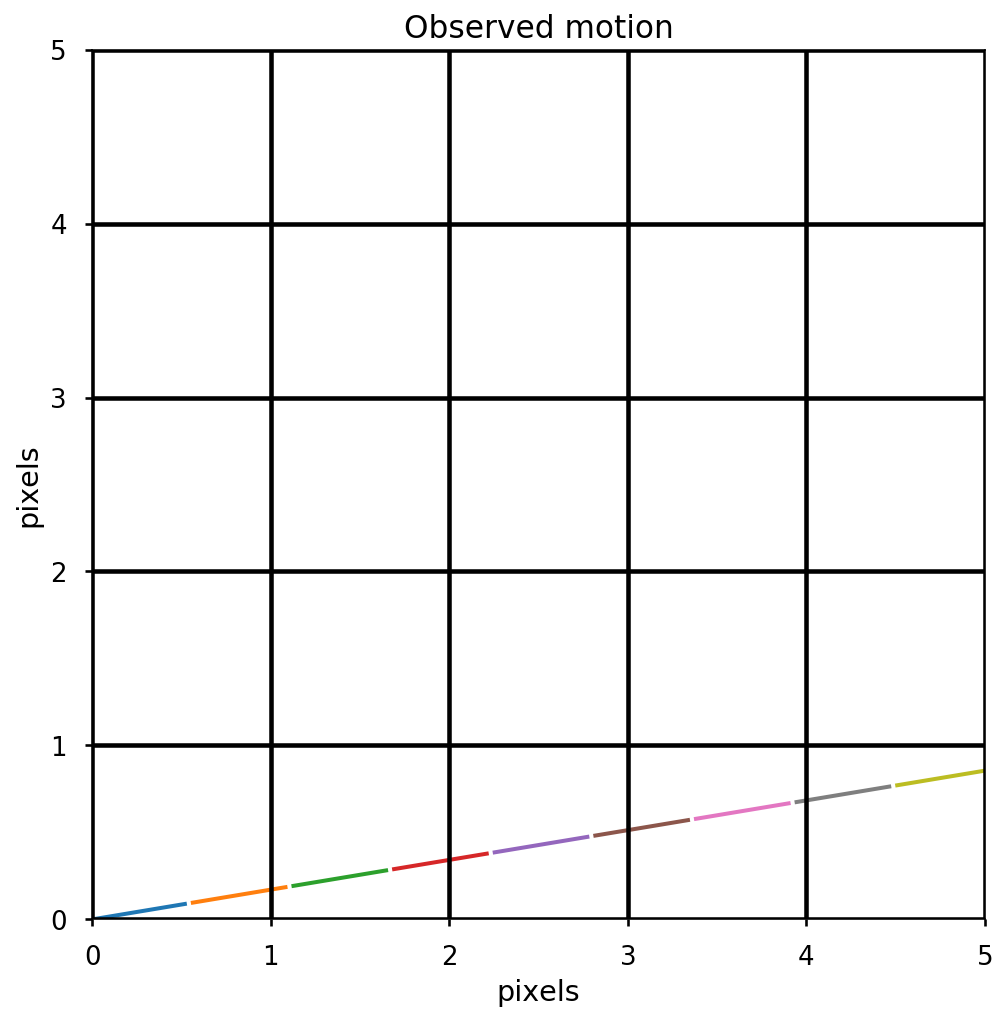

In [123]:
t0, t1, t2 = 0, 6.02, 6.54
x0, y0 = omega_x*t0, omega_y*t0
x1, y1 = omega_x*t1, omega_y*t1
x2, y2 = omega_x*t2, omega_y*t2

plt.figure(figsize=(8,8))

for frame_num in range(20):
    plt.plot([x0, x1], [y0, y1], lw = 2)    
    t0, t1 = t0+t2, t1+t2
    x0, y0 = omega_x*t0, omega_y*t0
    x1, y1 = omega_x*t1, omega_y*t1

for i in range(10):
    plt.axvline(i, color='k')
    plt.axhline(i, color='k')

plt.xlabel('pixels')
plt.ylabel('pixels')
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('Observed motion')
plt.savefig('../figures/readout_gaps_delivered.png', dpi=300, bbox_inches='tight');

## Estimate the signal to noise ratio

In [50]:
vmin, vmax = minmax.get_limits(dat)
vmin, vmax

(187391, 1806127)

In [76]:
p1, p8, p50, p90, p99 = np.percentile(dat.reshape(-1), [1, 8, 50, 90, 99])

In [77]:
x = np.linspace(p8, p90, 200)
y = histogram1d(dat.reshape(-1), bins=200, range=(p8, p90))

In [78]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(8, 90.0)
vmin, vmax = good_interval.get_limits(dat)

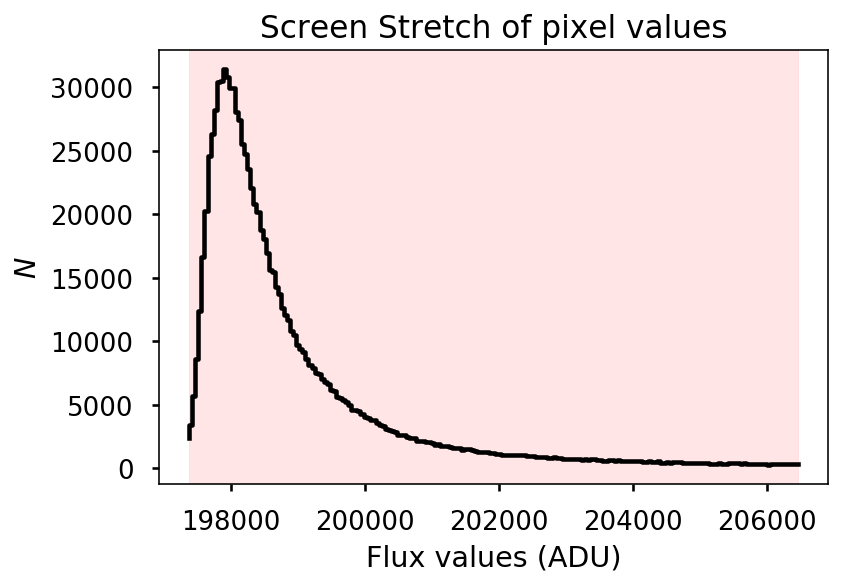

In [79]:
plt.step(x, y, 'k')
plt.axvspan(vmin, vmax, alpha=0.1, color='r')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Flux values (ADU)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');

Let's consider the standard deviation as the uncertainty.

In [80]:
p8

197377.0

In [81]:
dat_vec = dat.reshape(-1)

In [82]:
gi = (dat_vec > p8) & (dat_vec <200000)

In [84]:
sigma = np.nanstd(dat_vec[gi])

In [85]:
sigma

602.489043784921

In [90]:
s_n = (dat_vec - p8) / sigma
s_n = s_n[s_n>0]

In [91]:
log_s_n = np.log10(s_n)

1114292

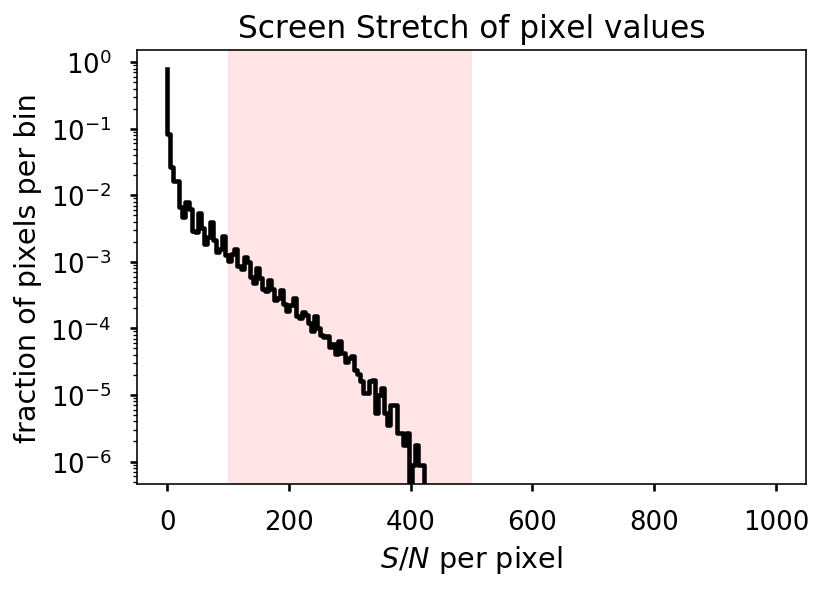

In [115]:
vmin, vmax = minmax.get_limits(s_n)
x = np.linspace(0, 1000, 200)
y = histogram1d(s_n, bins=200, range=(0, 1000))/len(s_n)
plt.step(x, y, 'k')
plt.axvspan(100,500, alpha=0.1, color='r')
plt.yscale('log')
plt.xlabel('$S/N$ per pixel')
plt.ylabel('fraction of pixels per bin')
plt.title('Screen Stretch of pixel values')
plt.savefig('../figures/sn_ratio_ch41_ffi3.png', dpi=300, bbox_inches='tight');

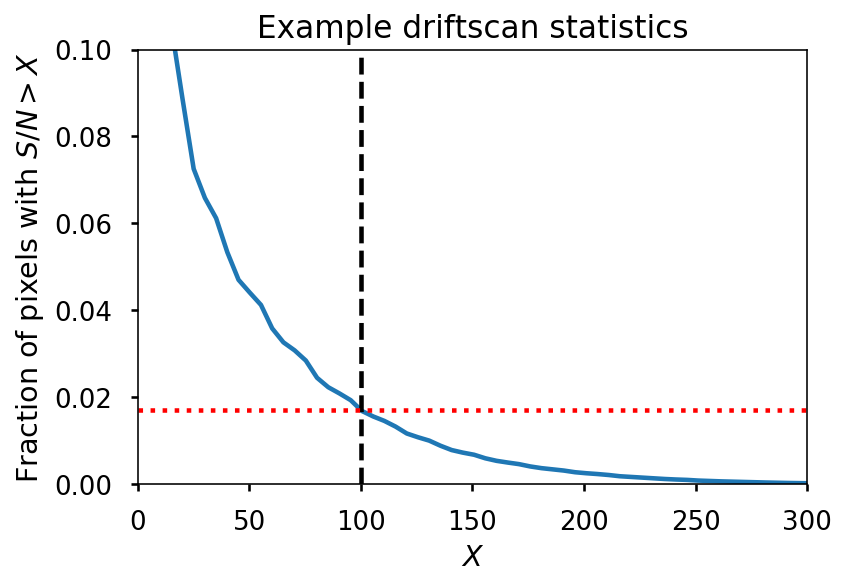

In [122]:
plt.plot(x[::-1], np.cumsum(y[::-1])/y.sum())
plt.xlabel('$X$')
plt.ylabel('Fraction of pixels with $S/N > X$')
plt.title('Example driftscan statistics')
plt.axvline(100, color='k', linestyle='dashed')
plt.axhline(0.017, color='r', linestyle='dotted')
plt.ylim(0, 0.1)
plt.xlim(0, 300)
plt.savefig('../figures/sn_ch41_ffi3_statistics.png', dpi=300,bbox_inches='tight');